In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools, os, torch

from sim import Scheduler, Random, Leitner
from data_process import process_original, reduce_df, eval_thresh, reduce_lexemes
from get_trajectory import get_traj

%load_ext autoreload
%autoreload 2

In [2]:
!cd data && ls

cleaned.csv    lexeme_map.csv


## Load data (clean if necesarry)

In [3]:
if not os.path.exists("data/cleaned.csv"):
    process_original()
    

df = pd.read_csv("data/cleaned.csv")

## Data Exploration

In [4]:
lang_map = {'de' : 0, 'en': 1, 'es': 2, 'fr': 3, 'it': 4, 'pt': 5}
l_map = pd.read_csv("data/lexeme_map.csv")

df.groupby('learning_language').count().loc[:, 'user_id']

learning_language
0    1452597
1    5014791
2    3407689
3    1873734
4     793935
5     311480
Name: user_id, dtype: int64

We have about 5 million english items, 3 million Spanish 1.9 million French and 1.4 million German. Italian and Portugese each have hundreds of thousands. It would be useful to restrict out studies to just the English users so we reduce the dimensionality of our action and state spaces.

There are 43.8 thousand learners (trajectories) we have to provide our RL agents.



In [5]:
df = df.loc[df['learning_language'] == 1].copy()
df = df.drop(['learning_language'], axis=1)
reduce_df(df)
df.loc[:, 'difficulty'] = df.loc[:, 'difficulty'].astype(np.float32)
df.loc[:, 'difficulty'] -= df.loc[:, 'difficulty'].mean()
df.loc[:, 'difficulty'] /= df.loc[:, 'difficulty'].std()

In [6]:
english_counts = df.groupby('lexeme_id').count().loc[:, 'timestamp']
n_lex = len(english_counts)
print(f"There are {n_lex} lexemes")

There are 2983 lexemes


In [7]:
n_items = int(250)

eval_thresh(df, english_counts, n_items)

For threshold 250 there are 36.98% lexemes above and 63.02% below

There would be 97.10% of data included and 2.90% of data excluded


In [8]:
df, included = reduce_lexemes(df, n_items)

In [ ]:
states, actions, itl, lti = get_traj(df, included)

## Run Behavioral Cloning

In [10]:
import torch.nn as nn
import torch
import random
import cs285.infrastructure.pytorch_util as ptu
from tqdm.notebook import trange, tqdm

In [11]:
traj_idxs = list(states.keys())
def sample_traj(states, actions, idxs, batch_size):
    first_idx = idxs.pop()
    states_cat = states[first_idx]
    actions_cat = actions[first_idx]
    while states_cat.shape[0] < batch_size and len(idxs) > 0:
        new_idx = idxs.pop()
        states_cat = np.concatenate((states_cat, states[new_idx]))
        actions_cat = np.concatenate((actions_cat, actions[new_idx]))
    return states_cat, actions_cat

In [26]:
state1, act1 = sample_traj(states, actions, [traj_idxs[0]], 1)
input_size = state1.shape[1]
output_size = act1.shape[1]
hidden_size = 3000
hidden_num = 2
activation = nn.ReLU
bc_loss = nn.MSELoss()
layers = [nn.Linear(input_size, hidden_size), activation()]
for i in range(hidden_num-1):
    layers.append(nn.Linear(hidden_size, hidden_size))
    layers.append(activation())
layers.append(nn.Linear(hidden_size, output_size))
bc_nn = nn.Sequential(*layers)
optimizer = torch.optim.Adam(bc_nn.parameters(), lr=1e-3)

In [27]:
train_iters = 2
train_losses = []
val_losses = []
batch_size = 200
val_batch_size = 200
split = int(np.floor(.9*len(traj_idxs)))
train_idxs = traj_idxs[:split]
val_idxs = traj_idxs[split:]
batches_per_epoch = split // batch_size

for i in tqdm(range(train_iters)):
    idxs = train_idxs[:]
    random.shuffle(idxs)
    val_shuffled = val_idxs[:]
    random.shuffle(val_shuffled)
    for j in tqdm(range(batches_per_epoch)):
        optimizer.zero_grad()
        s, a = sample_traj(states, actions, idxs[j*batch_size:(j+1)*batch_size], batch_size)
        result = bc_nn(ptu.from_numpy(s))
        loss = bc_loss(result, ptu.from_numpy(a))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        val_s, val_a = sample_traj(states, actions, val_shuffled[:], val_batch_size)
        val_losses.append(np.mean(np.square(ptu.to_numpy(bc_nn(ptu.from_numpy(val_s))) - val_a)))


Text(0.5, 1.0, 'MSE Of Actual vs Predicted Action (1100 lexemes)')

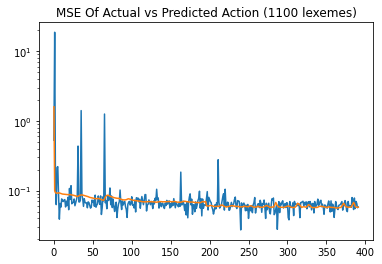

In [28]:
plt.plot(train_losses[0:500], label='training')
plt.plot(val_losses[0:500], label='validation')
plt.yscale("log")
plt.title("MSE Of Actual vs Predicted Action (1100 lexemes)")

In [24]:
actions[3][0, :].shape

(1103,)

In [ ]:
min(bc_nn.forward(s))